In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import KNNImputer
import datetime as dt
import sqlite3

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import pickle

import requests
import traceback
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, Float, String, DateTime

# import graphviz
# from graphviz import Source

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("rt_trips_DB_2018.txt", sep=";")

In [3]:
df.head(1)

,DATASOURCE,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,BASIN,TENDERLOT,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,NOTE
0,DB,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2967409,"


<h4>Check for null values</h4>

In [5]:
df.isna().sum()

DATASOURCE               0
DAYOFSERVICE             0
TRIPID                   0
LINEID                   0
ROUTEID                  0
DIRECTION                0
PLANNEDTIME_ARR          0
PLANNEDTIME_DEP          0
ACTUALTIME_ARR      137207
ACTUALTIME_DEP      164551
BASIN                    0
TENDERLOT          2182637
SUPPRESSED         2178304
JUSTIFICATIONID    2178307
LASTUPDATE               0
NOTE                     0
dtype: int64

<h4>Check for constant columns</h4>

In [6]:
# Display number of unique values per feature
df.nunique(axis=0)

DATASOURCE              1
DAYOFSERVICE          360
TRIPID             658964
LINEID                130
ROUTEID               588
DIRECTION               2
PLANNEDTIME_ARR     64461
PLANNEDTIME_DEP       791
ACTUALTIME_ARR      68122
ACTUALTIME_DEP      66771
BASIN                   1
TENDERLOT               0
SUPPRESSED              1
JUSTIFICATIONID      3526
LASTUPDATE            360
NOTE                46690
dtype: int64

In [7]:
# Drop empty/almost empty/constant features and features with undecipherable code
df.drop(["DATASOURCE", "BASIN", "TENDERLOT", "LASTUPDATE", "NOTE"], axis = 1, inplace=True)

In [8]:
df.head(1)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,NaN,NaN


<h4>Calculate percentage null values per route for ACTUALTIME_ARR and ACTUALTIME_DEP; imputation where &lt;30% missing following removal of outliers</h4>

In [9]:
unique_ROUTEID_list = df.ROUTEID.unique().tolist()
unique_ROUTEID_list.sort()

In [10]:
print("Number of routes:", len(unique_ROUTEID_list))
print("Sample of routes:", unique_ROUTEID_list[0:3])

Number of routes: 588
Sample of routes: ['102_10', '102_8', '102_9']


In [11]:
def nulls_per_route(dataframe, route_list):
    impute_ARR = []
    impute_DEP = []
    remaining = []
    for route in route_list:
        print(route)
        temp = dataframe.loc[dataframe["ROUTEID"] == route]
        pc_null_ARR = temp["ACTUALTIME_ARR"].isna().sum() / temp.shape[0] * 100 
        pc_null_DEP = temp["ACTUALTIME_DEP"].isna().sum() / temp.shape[0] * 100
        
        if pc_null_ARR < 30:
            impute_ARR.append(route)
            
        if pc_null_DEP < 30:
            impute_DEP.append(route)
            
        if (pc_null_ARR > 30) & (pc_null_DEP > 30):
            remaining.append(route)
            
        print("Entries:", temp.shape[0])
        print("ACTUALTIME_ARR % null:", pc_null_ARR)
        print("ACTUALTIME_DEP % null:", pc_null_DEP)
        print("***************")
    return impute_ARR, impute_DEP, remaining

In [12]:
impute_ARR, impute_DEP, other_routes = nulls_per_route(df, unique_ROUTEID_list)

102_10
Entries: 1093
ACTUALTIME_ARR % null: 4.94053064958829
ACTUALTIME_DEP % null: 57.45654162854529
***************
102_8
Entries: 9446
ACTUALTIME_ARR % null: 7.802244336226974
ACTUALTIME_DEP % null: 2.8901122168113487
***************
102_9
Entries: 9127
ACTUALTIME_ARR % null: 2.6076476388736713
ACTUALTIME_DEP % null: 1.3586063328585516
***************
104_15
Entries: 3807
ACTUALTIME_ARR % null: 1.024428684003152
ACTUALTIME_DEP % null: 20.278434462831626
***************
104_16
Entries: 3812
ACTUALTIME_ARR % null: 0.4459601259181532
ACTUALTIME_DEP % null: 0.4459601259181532
***************
111_10
Entries: 238
ACTUALTIME_ARR % null: 0.8403361344537815
ACTUALTIME_DEP % null: 0.0
***************
111_7
Entries: 4005
ACTUALTIME_ARR % null: 2.9962546816479403
ACTUALTIME_DEP % null: 8.913857677902621
***************
111_8
Entries: 2886
ACTUALTIME_ARR % null: 4.435204435204435
ACTUALTIME_DEP % null: 1.3513513513513513
***************
111_9
Entries: 719
ACTUALTIME_ARR % null: 8.90125173852573


Entries: 635
ACTUALTIME_ARR % null: 4.251968503937007
ACTUALTIME_DEP % null: 0.9448818897637795
***************
145_107
Entries: 91
ACTUALTIME_ARR % null: 8.791208791208792
ACTUALTIME_DEP % null: 27.472527472527474
***************
145_108
Entries: 140
ACTUALTIME_ARR % null: 0.7142857142857143
ACTUALTIME_DEP % null: 22.857142857142858
***************
145_86
Entries: 573
ACTUALTIME_ARR % null: 8.726003490401396
ACTUALTIME_DEP % null: 83.7696335078534
***************
145_87
Entries: 195
ACTUALTIME_ARR % null: 4.615384615384616
ACTUALTIME_DEP % null: 36.92307692307693
***************
145_88
Entries: 180
ACTUALTIME_ARR % null: 4.444444444444445
ACTUALTIME_DEP % null: 89.44444444444444
***************
145_89
Entries: 137
ACTUALTIME_ARR % null: 5.839416058394161
ACTUALTIME_DEP % null: 81.75182481751825
***************
145_91
Entries: 1442
ACTUALTIME_ARR % null: 3.536754507628294
ACTUALTIME_DEP % null: 18.654646324549237
***************
145_93
Entries: 243
ACTUALTIME_ARR % null: 13.58024691358

Entries: 53
ACTUALTIME_ARR % null: 0.0
ACTUALTIME_DEP % null: 37.735849056603776
***************
17_19
Entries: 176
ACTUALTIME_ARR % null: 2.840909090909091
ACTUALTIME_DEP % null: 97.72727272727273
***************
184_28
Entries: 7603
ACTUALTIME_ARR % null: 1.3547283966855188
ACTUALTIME_DEP % null: 5.024332500328818
***************
184_29
Entries: 7724
ACTUALTIME_ARR % null: 3.8710512687726566
ACTUALTIME_DEP % null: 0.29777317452097357
***************
185_50
Entries: 1677
ACTUALTIME_ARR % null: 2.206320810971974
ACTUALTIME_DEP % null: 0.4770423375074538
***************
185_51
Entries: 1030
ACTUALTIME_ARR % null: 0.7766990291262136
ACTUALTIME_DEP % null: 3.3980582524271843
***************
185_52
Entries: 886
ACTUALTIME_ARR % null: 1.580135440180587
ACTUALTIME_DEP % null: 1.1286681715575622
***************
185_53
Entries: 2076
ACTUALTIME_ARR % null: 2.9865125240847785
ACTUALTIME_DEP % null: 0.9633911368015413
***************
185_54
Entries: 247
ACTUALTIME_ARR % null: 4.048582995951417
AC

Entries: 240
ACTUALTIME_ARR % null: 0.4166666666666667
ACTUALTIME_DEP % null: 7.5
***************
27B_39
Entries: 239
ACTUALTIME_ARR % null: 1.2552301255230125
ACTUALTIME_DEP % null: 3.765690376569038
***************
27B_40
Entries: 992
ACTUALTIME_ARR % null: 0.10080645161290322
ACTUALTIME_DEP % null: 43.145161290322584
***************
27X_42
Entries: 474
ACTUALTIME_ARR % null: 1.6877637130801686
ACTUALTIME_DEP % null: 8.438818565400844
***************
27X_43
Entries: 455
ACTUALTIME_ARR % null: 2.197802197802198
ACTUALTIME_DEP % null: 5.274725274725275
***************
27_12
Entries: 991
ACTUALTIME_ARR % null: 1.513622603430878
ACTUALTIME_DEP % null: 10.696266397578205
***************
27_17
Entries: 23518
ACTUALTIME_ARR % null: 5.863593843013862
ACTUALTIME_DEP % null: 10.183689089208265
***************
27_18
Entries: 338
ACTUALTIME_ARR % null: 0.0
ACTUALTIME_DEP % null: 1.7751479289940828
***************
27_19
Entries: 24398
ACTUALTIME_ARR % null: 8.369538486761211
ACTUALTIME_DEP % null

Entries: 26402
ACTUALTIME_ARR % null: 15.495038254677675
ACTUALTIME_DEP % null: 6.105598060752973
***************
39A_41
Entries: 334
ACTUALTIME_ARR % null: 4.491017964071856
ACTUALTIME_DEP % null: 21.55688622754491
***************
39A_42
Entries: 669
ACTUALTIME_ARR % null: 2.5411061285500747
ACTUALTIME_DEP % null: 4.932735426008969
***************
39A_43
Entries: 27669
ACTUALTIME_ARR % null: 5.052585926488128
ACTUALTIME_DEP % null: 9.057067476236943
***************
39A_44
Entries: 157
ACTUALTIME_ARR % null: 68.78980891719745
ACTUALTIME_DEP % null: 1.910828025477707
***************
39A_45
Entries: 70
ACTUALTIME_ARR % null: 27.142857142857142
ACTUALTIME_DEP % null: 1.4285714285714286
***************
39X_1
Entries: 937
ACTUALTIME_ARR % null: 45.78441835645678
ACTUALTIME_DEP % null: 1.7075773745997866
***************
39X_2
Entries: 134
ACTUALTIME_ARR % null: 6.7164179104477615
ACTUALTIME_DEP % null: 0.7462686567164178
***************
39X_3
Entries: 807
ACTUALTIME_ARR % null: 4.46096654275

Entries: 15532
ACTUALTIME_ARR % null: 3.6183363378830804
ACTUALTIME_DEP % null: 4.9703837239248
***************
41_8
Entries: 919
ACTUALTIME_ARR % null: 0.8705114254624592
ACTUALTIME_DEP % null: 7.725788900979326
***************
41_9
Entries: 226
ACTUALTIME_ARR % null: 10.176991150442479
ACTUALTIME_DEP % null: 0.0
***************
42D_50
Entries: 179
ACTUALTIME_ARR % null: 13.966480446927374
ACTUALTIME_DEP % null: 0.5586592178770949
***************
42D_51
Entries: 181
ACTUALTIME_ARR % null: 0.5524861878453038
ACTUALTIME_DEP % null: 2.209944751381215
***************
42_42
Entries: 12427
ACTUALTIME_ARR % null: 5.858211957833749
ACTUALTIME_DEP % null: 2.5348032509857568
***************
42_44
Entries: 12662
ACTUALTIME_ARR % null: 0.631811720107408
ACTUALTIME_DEP % null: 5.236139630390143
***************
43_84
Entries: 8001
ACTUALTIME_ARR % null: 5.024371953505812
ACTUALTIME_DEP % null: 4.061992250968629
***************
43_85
Entries: 244
ACTUALTIME_ARR % null: 2.459016393442623
ACTUALTIME_D

Entries: 473
ACTUALTIME_ARR % null: 91.5433403805497
ACTUALTIME_DEP % null: 31.289640591966172
***************
61_108
Entries: 5411
ACTUALTIME_ARR % null: 4.269081500646831
ACTUALTIME_DEP % null: 7.2629828127887635
***************
61_109
Entries: 727
ACTUALTIME_ARR % null: 0.9628610729023385
ACTUALTIME_DEP % null: 86.38239339752407
***************
63_25
Entries: 1789
ACTUALTIME_ARR % null: 16.713247624371157
ACTUALTIME_DEP % null: 0.5030743432084964
***************
63_26
Entries: 5552
ACTUALTIME_ARR % null: 2.287463976945245
ACTUALTIME_DEP % null: 1.1527377521613833
***************
63_27
Entries: 190
ACTUALTIME_ARR % null: 1.5789473684210527
ACTUALTIME_DEP % null: 0.0
***************
63_28
Entries: 1881
ACTUALTIME_ARR % null: 1.063264221158958
ACTUALTIME_DEP % null: 9.675704412546517
***************
63_29
Entries: 38
ACTUALTIME_ARR % null: 0.0
ACTUALTIME_DEP % null: 63.1578947368421
***************
63_30
Entries: 5308
ACTUALTIME_ARR % null: 1.46948003014318
ACTUALTIME_DEP % null: 1.639

Entries: 159
ACTUALTIME_ARR % null: 0.628930817610063
ACTUALTIME_DEP % null: 0.628930817610063
***************
69_43
Entries: 2416
ACTUALTIME_ARR % null: 3.5182119205298013
ACTUALTIME_DEP % null: 1.73841059602649
***************
69_44
Entries: 2527
ACTUALTIME_ARR % null: 16.383062920459043
ACTUALTIME_DEP % null: 7.004352987732489
***************
69_45
Entries: 3126
ACTUALTIME_ARR % null: 1.2795905310300704
ACTUALTIME_DEP % null: 0.8317338451695457
***************
69_46
Entries: 183
ACTUALTIME_ARR % null: 0.0
ACTUALTIME_DEP % null: 0.0
***************
69_47
Entries: 3500
ACTUALTIME_ARR % null: 12.2
ACTUALTIME_DEP % null: 6.771428571428571
***************
70D_70
Entries: 179
ACTUALTIME_ARR % null: 5.58659217877095
ACTUALTIME_DEP % null: 1.675977653631285
***************
70D_71
Entries: 181
ACTUALTIME_ARR % null: 2.209944751381215
ACTUALTIME_DEP % null: 23.204419889502763
***************
70_60
Entries: 7161
ACTUALTIME_ARR % null: 1.6059209607596703
ACTUALTIME_DEP % null: 9.928780896522833

Entries: 40
ACTUALTIME_ARR % null: 7.5
ACTUALTIME_DEP % null: 20.0
***************
84X_60
Entries: 168
ACTUALTIME_ARR % null: 2.380952380952381
ACTUALTIME_DEP % null: 5.357142857142857
***************
84X_61
Entries: 809
ACTUALTIME_ARR % null: 25.46353522867738
ACTUALTIME_DEP % null: 5.562422744128554
***************
84X_62
Entries: 1179
ACTUALTIME_ARR % null: 13.740458015267176
ACTUALTIME_DEP % null: 24.851569126378287
***************
84X_63
Entries: 140
ACTUALTIME_ARR % null: 11.428571428571429
ACTUALTIME_DEP % null: 15.714285714285714
***************
84X_64
Entries: 84
ACTUALTIME_ARR % null: 1.1904761904761905
ACTUALTIME_DEP % null: 7.142857142857142
***************
84X_65
Entries: 126
ACTUALTIME_ARR % null: 11.904761904761903
ACTUALTIME_DEP % null: 7.142857142857142
***************
84_27
Entries: 4330
ACTUALTIME_ARR % null: 6.304849884526559
ACTUALTIME_DEP % null: 4.803695150115474
***************
84_28
Entries: 1345
ACTUALTIME_ARR % null: 3.3457249070631967
ACTUALTIME_DEP % null: 

In [13]:
len(impute_ARR)

542

In [14]:
len(impute_DEP)

530

In [15]:
# Routes where there is >30% nulls for both ACTUALTIME_ARR and ACTUALTIME_DEP; all null entries will be removed
other_routes

['116_3', '13_75', '27A_7', '61_107', '66_14', '7_67']

<h4>Remove entries where imputation is inappropriate i.e. where percentage missing data >30</h4>

In [16]:
# Remove entries where ACTUALTIME_ARR is null and ROUTEID not in impute_ARR or ACTUALTIME_DEP is null and ROUTEID not in impute_DEP
df_updated = df.drop(df[(df["ACTUALTIME_ARR"].isna() & ~df["ROUTEID"].isin(impute_ARR)) | (df["ACTUALTIME_DEP"].isna() & ~df["ROUTEID"].isin(impute_DEP))].index)

In [17]:
# Check behaviour was as expected
test = df.loc[df["ROUTEID"] == "102_10"]
print(test.ACTUALTIME_ARR.isna().sum())
print(test.ACTUALTIME_DEP.isna().sum())

54
628


In [18]:
test1 = df_updated.loc[df_updated["ROUTEID"] == "102_10"]
print(test1.ACTUALTIME_ARR.isna().sum())
print(test1.ACTUALTIME_DEP.isna().sum())

2
0


<p>In the example above we examine route 102_10. For route 102, we are deleting those entries for which ACTUALTIME_DEP is null, as the proportion of null values for this feature is approximately 57%. On deletion of these entries, only 2 entries remain for which ACTUALTIME_ARR is null and which will need to be imputed.</p>

In [19]:
test.loc[test["ACTUALTIME_ARR"].isna()]

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID
16651,10-APR-18 00:00:00,6620295,102,102_10,2,27821,26400,NaN,NaN,NaN,NaN
129372,19-MAR-18 00:00:00,6388407,102,102_10,2,27880,26400,NaN,NaN,NaN,NaN
269681,02-FEB-18 00:00:00,6234556,102,102_10,2,27935,26400,NaN,NaN,NaN,NaN
275598,26-MAY-18 00:00:00,6769312,102,102_10,2,27950,26400,NaN,NaN,NaN,NaN
285883,19-JUN-18 00:00:00,7025236,102,102_10,2,27692,26400,NaN,NaN,NaN,NaN
289657,09-AUG-18 00:00:00,7316796,102,102_10,2,27700,26400,NaN,NaN,NaN,NaN
290054,05-JUL-18 00:00:00,7147711,102,102_10,2,27716,26400,NaN,NaN,NaN,NaN
307000,31-AUG-18 00:00:00,7510664,102,102_10,2,27768,26400,NaN,NaN,NaN,NaN
327782,24-APR-18 00:00:00,6641734,102,102_10,2,27221,25800,NaN,25610.0,NaN,NaN
401172,04-AUG-18 00:00:00,7318793,102,102_10,2,27648,26400,NaN,NaN,NaN,NaN


In [20]:
df_updated.shape

(2128546, 11)

In [21]:
df_updated.isna().sum()

DAYOFSERVICE             0
TRIPID                   0
LINEID                   0
ROUTEID                  0
DIRECTION                0
PLANNEDTIME_ARR          0
PLANNEDTIME_DEP          0
ACTUALTIME_ARR      117966
ACTUALTIME_DEP      125603
SUPPRESSED         2124397
JUSTIFICATIONID    2124400
dtype: int64

In [22]:
def to_timestamp(date):
    ts = int(dt.datetime.timestamp(dt.datetime.strptime(date, '%d-%b-%y %H:%M:%S')))
    return ts

df_updated["dt"] = df_updated["DAYOFSERVICE"].apply(to_timestamp)

In [23]:
df_updated["dt"] = df_updated["dt"] + (df_updated["PLANNEDTIME_DEP"])

In [24]:
def to_datetime(num):
    stamp = pd.Timestamp(num, unit="s")
    return stamp

df_updated["dt"] = df_updated["dt"].apply(to_datetime)

In [25]:
def to_nearest_hour(num):
    num = num.replace(minute=0, second=0, microsecond=0)
    return num

df_updated["dt"] = df_updated["dt"].apply(to_nearest_hour)

In [26]:
df_updated.drop(["DAYOFSERVICE"], axis = 1, inplace=True)

In [27]:
df_updated.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID,dt
0,6253783,68,68_80,1,87245,84600,87524.0,84600.0,NaN,NaN,2018-02-07 23:00:00
1,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,NaN,NaN,2018-02-07 07:00:00
2,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,NaN,NaN,2018-02-07 08:00:00
3,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,NaN,NaN,2018-02-07 15:00:00
4,6253175,14,14_15,1,85383,81600,84682.0,81608.0,NaN,NaN,2018-02-07 22:00:00


In [28]:
df_updated.shape

(2128546, 11)

<h4>Further investigate features and check logical integrity of data</h4>
<p>1. Check for entries where PLANNEDTIME_ARR precedes PLANNEDTIME_DEP</p>

In [29]:
test2 = df_updated.loc[df_updated["PLANNEDTIME_ARR"] < df_updated["PLANNEDTIME_DEP"]]

In [30]:
test2.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID,dt


<p>2. Check for entries where ACTUALTIME_ARR precedes ACTUALTIME_DEP</p>

In [31]:
test3 = df_updated.loc[df_updated["ACTUALTIME_ARR"] < df_updated["ACTUALTIME_DEP"]]

In [32]:
test3.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID,dt
1619,7029435,150,150_8,1,75653,73800,76232.0,83371.0,NaN,NaN,2018-06-21 19:00:00
4473,7766397,65,65_74,1,38044,34200,38852.0,42653.0,NaN,NaN,2018-09-26 08:00:00
42164,7761061,150,150_8,1,75510,73800,76397.0,76692.0,NaN,NaN,2018-09-28 19:00:00
46421,7021290,43,43_84,1,59845,56400,59314.0,59962.0,NaN,NaN,2018-06-19 14:00:00
51585,6391220,56A,56A_31,1,74509,71100,74755.0,75180.0,NaN,NaN,2018-03-22 19:00:00


In [33]:
test3.shape

(103, 11)

In [34]:
test3_indices = df_updated[df_updated["ACTUALTIME_DEP"] > df_updated["ACTUALTIME_ARR"]].index
len(test3_indices.tolist())

103

In [35]:
df_updated.shape

(2128546, 11)

In [36]:
df_updated.drop(test3_indices, inplace=True)

In [37]:
df_updated.shape

(2128443, 11)

<p>3. Explore entries where SUPPRESSED is flagged</p>

In [38]:
test4 = df_updated.loc[df_updated["SUPPRESSED"] == 0]
test4.head()

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID,dt
1783,6269995,45A,45A_60,1,68767,65700,NaN,65746.0,0.0,194642.0,2018-02-18 18:00:00
2363,6399287,41C,41C_78,1,71543,68400,NaN,68643.0,0.0,205589.0,2018-03-16 19:00:00
3485,7758815,13,13_72,2,77076,72000,77726.0,NaN,0.0,271333.0,2018-09-28 19:00:00
3873,6277942,54A,54A_12,2,56910,54000,NaN,53972.0,0.0,194644.0,2018-02-18 15:00:00
4353,6400436,16,16_20,1,66230,61200,NaN,63250.0,0.0,204650.0,2018-03-10 17:00:00


In [39]:
test4.shape

(4149, 11)

In [41]:
pd.set_option('display.max_rows', 257)
test4["ROUTEID"].value_counts()

42_42      309
27_19      128
43_84       89
145_105     87
16_20       83
40_27       80
46A_67      71
41_3        66
37_14       66
15_16       64
49_27       63
70_67       60
9_5         60
140_19      56
145_102     56
40_31       55
79_10       54
39A_40      54
65B_65      52
39_20       51
25B_274     50
122_14      47
83_16       47
41_7        47
79A_27      46
123_36      45
25A_273     45
77A_29      43
25B_271     43
27_17       43
15_17       42
9_7         42
41C_78      41
41_9        39
151_15      38
38A_20      38
39A_43      36
130_11      34
123_34      34
67_6        34
14_15       33
67_4        33
4_10        33
38_9        33
43_88       32
1_40        32
1_37        31
39_21       30
14_16       30
76_36       29
27B_34      27
54A_11      27
122_16      26
46A_74      25
25A_270     25
83_22       24
29A_14      23
79_11       23
70_60       22
65_74       22
33B_56      21
11_40       21
75_19       20
31_15       20
7A_85       20
79A_28      20
151_17    

In [42]:
test4.loc[~test4["JUSTIFICATIONID"].isna()]

,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,SUPPRESSED,JUSTIFICATIONID,dt
1783,6269995,45A,45A_60,1,68767,65700,NaN,65746.0,0.0,194642.0,2018-02-18 18:00:00
2363,6399287,41C,41C_78,1,71543,68400,NaN,68643.0,0.0,205589.0,2018-03-16 19:00:00
3485,7758815,13,13_72,2,77076,72000,77726.0,NaN,0.0,271333.0,2018-09-28 19:00:00
3873,6277942,54A,54A_12,2,56910,54000,NaN,53972.0,0.0,194644.0,2018-02-18 15:00:00
4353,6400436,16,16_20,1,66230,61200,NaN,63250.0,0.0,204650.0,2018-03-10 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2178663,6755557,40,40_27,1,54406,48240,53877.0,NaN,0.0,231821.0,2018-05-15 12:00:00
2180333,6756431,40D,40D_101,1,83064,81000,NaN,80899.0,0.0,231822.0,2018-05-15 21:00:00
2181600,6761229,46A,46A_67,2,62024,56880,61946.0,NaN,0.0,231784.0,2018-05-14 14:00:00
2181789,6759169,66,66_13,2,41797,38100,41937.0,NaN,0.0,231826.0,2018-05-15 09:00:00


In [43]:
test4_mode = test4.ROUTEID.mode()[0]
print(test4_mode)

42_42


In [44]:
test4a = test4.loc[test4["ROUTEID"] == test4_mode]

In [45]:
test4a["JOURNEYTIME"] = test4a["ACTUALTIME_ARR"] - test4a["ACTUALTIME_DEP"]

In [46]:
print("Mean journey time for route 42_42 for suppressed 0 subset:", test4a.JOURNEYTIME.mean())

Mean journey time for route 42_42 for suppressed 0 subset: 3499.2131147540986


In [47]:
test4b = df_updated.loc[df_updated["ROUTEID"] == test4_mode]

In [48]:
test4b["JOURNEYTIME"] = test4b["ACTUALTIME_ARR"] - test4b["ACTUALTIME_DEP"]

In [49]:
print("Mean journey time for route 42_42 for whole dataset:", test4b.JOURNEYTIME.mean())

Mean journey time for route 42_42 for whole dataset: 3378.4834239607085


<p>It is assumed that SUPPRESSED is flagged as 0 for those trips on which a fault occurred but which were still completed successfully. Based on this assumption journey time would be longer for these trips, and comparing mean journey time for route 42_42 in this subset to mean journey time for the same route in the whole dataset, we can see that this is the case. These entries will be removed.</p>

In [85]:
test4_indices = df_updated[df_updated["SUPPRESSED"] == 0].index
len(test4_indices.tolist())

4149

In [86]:
df_updated.shape

(2128443, 11)

In [87]:
df_updated.drop(test4_indices, inplace=True)

In [5]:
df_updated.drop(["SUPPRESSED", "JUSTIFICATIONID"], axis=1, inplace=True)

In [6]:
df_updated.shape

(2124294, 9)

<h4>Check for outliers</h4>

<AxesSubplot:xlabel='PLANNEDTIME_ARR'>

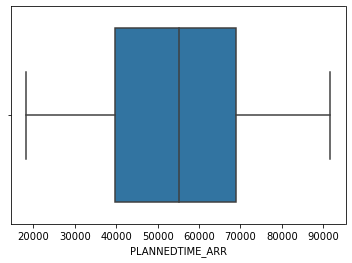

In [90]:
# Create boxplot for feature PLANNEDTIME_ARR
sns.boxplot(df_updated["PLANNEDTIME_ARR"])

<AxesSubplot:xlabel='PLANNEDTIME_DEP'>

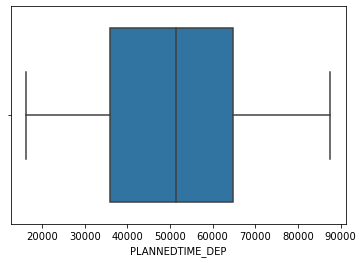

In [91]:
# Create boxplot for feature PLANNEDTIME_ARR
sns.boxplot(df_updated["PLANNEDTIME_DEP"])

<AxesSubplot:xlabel='ACTUALTIME_ARR'>

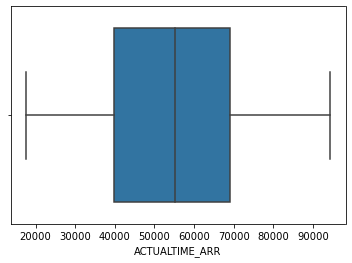

In [92]:
# Create boxplot for feature PLANNEDTIME_ARR
sns.boxplot(df_updated["ACTUALTIME_ARR"])

<AxesSubplot:xlabel='ACTUALTIME_DEP'>

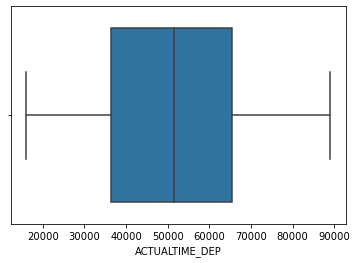

In [93]:
# Create boxplot for feature PLANNEDTIME_ARR
sns.boxplot(df_updated["ACTUALTIME_DEP"])

In [94]:
df_updated.shape

(2124294, 11)

In [7]:
df_updated.to_csv("initial_trips_cleaning.csv", index=False)

In [4]:
df_updated = pd.read_csv("initial_trips_cleaning.csv")

In [97]:
df.shape

(2124294, 11)